# Machine Learning Project 
## The aim of this project is to use supervised machine learning to create a regression model that can predict discharge dates.

# Install Packages 


In [4]:
#for EDA
import pandas as pd
import numpy as np
import pandas as pd 


#forpreprocessing
import hashlib
import datetime

# for machine learning  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#for visualisations
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image

# EDA

In [5]:
# read in dataset
df = pd.read_csv("healthcare_dataset.csv")

df # high level overview of the dataset

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Tiffany Ramirez,81,Female,O-,Diabetes,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive
1,Ruben Burns,35,Male,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal
2,Chad Byrd,61,Male,B-,Obesity,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal
3,Antonio Frederick,49,Male,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal
4,Mrs. Brandy Flowers,51,Male,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,James Hood,83,Male,A+,Obesity,2022-07-29,Samuel Moody,"Wood, Martin and Simmons",UnitedHealthcare,39606.840083,110,Elective,2022-08-02,Ibuprofen,Abnormal
9996,Stephanie Evans,47,Female,AB+,Arthritis,2022-01-06,Christopher Yates,Nash-Krueger,Blue Cross,5995.717488,244,Emergency,2022-01-29,Ibuprofen,Normal
9997,Christopher Martinez,54,Male,B-,Arthritis,2022-07-01,Robert Nicholson,Larson and Sons,Blue Cross,49559.202905,312,Elective,2022-07-15,Ibuprofen,Normal
9998,Amanda Duke,84,Male,A+,Arthritis,2020-02-06,Jamie Lewis,Wilson-Lyons,UnitedHealthcare,25236.344761,420,Urgent,2020-02-26,Penicillin,Normal


In [6]:
# looking at the data types
df.dtypes
df.info()

# checking for missing variables 
df.isnull().sum()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                10000 non-null  object 
 1   Age                 10000 non-null  int64  
 2   Gender              10000 non-null  object 
 3   Blood Type          10000 non-null  object 
 4   Medical Condition   10000 non-null  object 
 5   Date of Admission   10000 non-null  object 
 6   Doctor              10000 non-null  object 
 7   Hospital            10000 non-null  object 
 8   Insurance Provider  10000 non-null  object 
 9   Billing Amount      10000 non-null  float64
 10  Room Number         10000 non-null  int64  
 11  Admission Type      10000 non-null  object 
 12  Discharge Date      10000 non-null  object 
 13  Medication          10000 non-null  object 
 14  Test Results        10000 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 1.1+

Name                   object
Age                     int64
Gender                 object
Blood Type             object
Medical Condition      object
Date of Admission      object
Doctor                 object
Hospital               object
Insurance Provider     object
Billing Amount        float64
Room Number             int64
Admission Type         object
Discharge Date         object
Medication             object
Test Results           object
dtype: object

In [7]:
# insights into  the data 
df['Medical Condition'].value_counts() 
df['Admission Type'].value_counts()
df['Medication'].value_counts()
df['Gender'].value_counts()
df['Test Results'].value_counts()

Abnormal        3456
Inconclusive    3277
Normal          3267
Name: Test Results, dtype: int64

# Description of Variables

### Insight into Duration of Stay

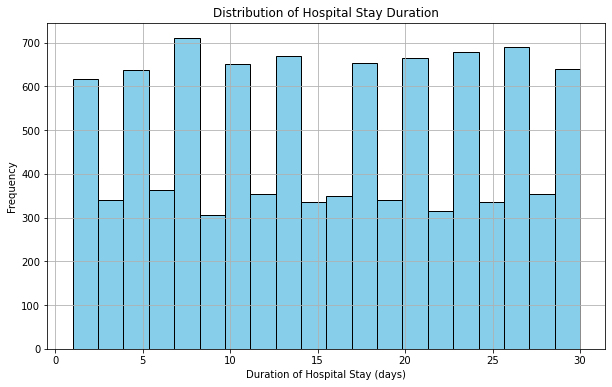

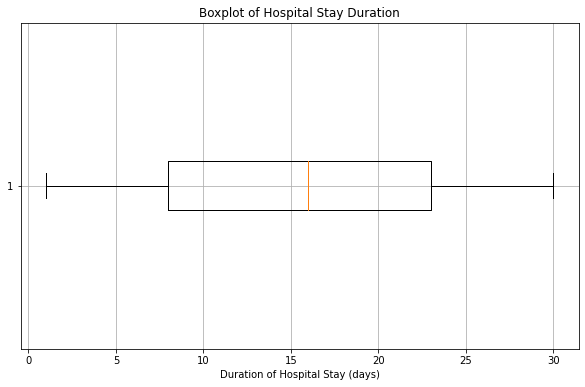

In [8]:
# convert date features to datetime format
df["Date of Admission"] = pd.to_datetime(df["Date of Admission"])
df["Discharge Date"] = pd.to_datetime(df["Discharge Date"])

# calculate duration of hospital stay
df["Hospital Stay Duration"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days

# histogram of hospital stay duration
plt.figure(figsize=(10, 6))
plt.hist(df["Hospital Stay Duration"], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Hospital Stay Duration")
plt.xlabel("Duration of Hospital Stay (days)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# boxplot of hospital stay duration
plt.figure(figsize=(10, 6))
plt.boxplot(df["Hospital Stay Duration"], vert=False)
plt.title("Boxplot of Hospital Stay Duration")
plt.xlabel("Duration of Hospital Stay (days)")
plt.grid(True)
plt.show()



### Anonymization

In [9]:
# function to hash sensitive information and truncate to 5 characters
def hash_and_truncate(info):
    # Encode the input string to bytes
    info_bytes = info.encode('utf-8')
    # apply SHA-256 hashing
    hashed_info = hashlib.sha256(info_bytes).hexdigest()
    # truncate the hashed value to 5 characters
    truncated_hash = hashed_info[:5]
    return truncated_hash

# anonymize sensitive columns using truncated cryptographic hashing
df["Name"] = df["Name"].apply(lambda x: hash_and_truncate(x) if isinstance(x, str) else x)
df["Doctor"] = df["Doctor"].apply(lambda x: hash_and_truncate(x) if isinstance(x, str) else x)
df["Hospital"] = df["Hospital"].apply(lambda x: hash_and_truncate(x) if isinstance(x, str) else x)
df["Insurance Provider"] = df["Insurance Provider"].apply(lambda x: hash_and_truncate(x) if isinstance(x, str) else x)

# display anonymized dataframe
df

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Hospital Stay Duration
0,0e9a7,81,Female,O-,Diabetes,2022-11-17,cefdd,b17a2,4893b,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive,14
1,c07bb,35,Male,O+,Asthma,2023-06-01,c99b4,186a7,22418,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal,14
2,c6a32,61,Male,B-,Obesity,2019-01-09,993e6,3e7b9,4893b,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal,30
3,ab54f,49,Male,B-,Asthma,2020-05-02,e1eee,2ba67,4893b,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal,1
4,2d6ef,51,Male,O-,Arthritis,2021-07-09,ba237,2bbb5,22418,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,33bad,83,Male,A+,Obesity,2022-07-29,a56b2,d2678,22418,39606.840083,110,Elective,2022-08-02,Ibuprofen,Abnormal,4
9996,14941,47,Female,AB+,Arthritis,2022-01-06,a00f3,93b91,4c386,5995.717488,244,Emergency,2022-01-29,Ibuprofen,Normal,23
9997,55892,54,Male,B-,Arthritis,2022-07-01,036d1,906f3,4c386,49559.202905,312,Elective,2022-07-15,Ibuprofen,Normal,14
9998,edaa6,84,Male,A+,Arthritis,2020-02-06,9d66e,0ad76,22418,25236.344761,420,Urgent,2020-02-26,Penicillin,Normal,20


## Preprocessing

In [10]:
# separate features (X) and target variable (y)
X = df.drop(columns=['Name', 'Billing Amount'])
y = df['Hospital Stay Duration']

In [11]:
# split the data into Training and Testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# prepare for the Preprocessor:
numeric_features = ['Age']
categorical_features = ['Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Admission Type', 'Room Number', 'Medication', 'Test Results']

In [12]:
# set up transformers and preprocessor

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [13]:
# define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 78.97369934999999


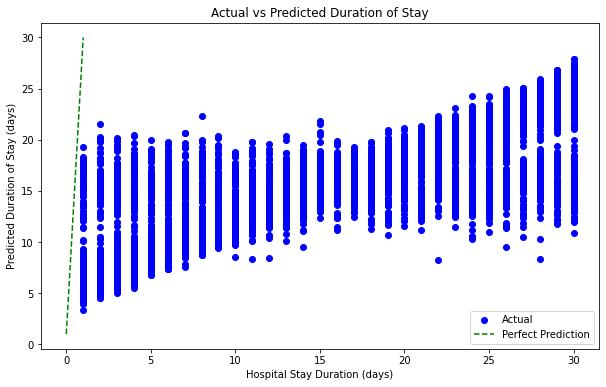

In [17]:
# use the trained model to predict duration of stay
df['Predicted Duration'] = model.predict(X)

# plot hospital stay duration vs predicted duration of stay
plt.figure(figsize=(10, 6))

# plot actual data
plt.scatter(df['Hospital Stay Duration'], df['Predicted Duration'], color='blue', label='Actual', marker='o')

plt.plot([df['Hospital Stay Duration'].min(), df['Hospital Stay Duration'].max()],  
         color='green', linestyle='--', label='Perfect Prediction')

plt.title('Actual vs Predicted Duration of Stay')
plt.xlabel('Hospital Stay Duration (days)')
plt.ylabel('Predicted Duration of Stay (days)')
plt.legend()
plt.show()
